In [71]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
from fastai import *
import pandas as pd

In [72]:
from fastai.tabular import *

In [73]:
path = Path('data_fcn')

In [74]:
train_df=pd.read_pickle('df_fixed.pkl')

In [75]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [76]:
procs=[Categorify]


In [78]:
cat_vars = ['atom_name', 'residue_name',
       'residue_number','element_symbol']

In [79]:
cont_vars = ['x_ca', 'y_ca', 'z_ca']

In [80]:
train_df = train_df.drop(['b_factor','chain_id'],axis=1)
train_df.head()

,atom_number,atom_name,residue_name,residue_number,x_coord,y_coord,z_coord,element_symbol,x_ca,y_ca,z_ca
2852,2853,N,TYR,359,111.214,14.882,-0.665,N,110.510,13.878,-1.488
71,72,N,SER,9,-11.430,16.799,36.183,N,-10.300,16.791,35.260
1196,1197,CE1,HIS,135,71.288,18.069,52.840,C,68.606,16.887,49.480
1830,1831,HA,SER,121,-13.463,12.801,-6.611,H,-12.683,13.322,-6.364
748,749,C,CYS,49,-3.688,-0.836,2.782,C,-3.566,-1.823,1.619


In [81]:
valid_idx = range(20000)

In [82]:
dep_var = ['x_coord', 'y_coord', 'z_coord']

In [83]:
y=train_df[dep_var]


In [84]:
y

,x_coord,y_coord,z_coord
2852,111.214,14.882,-0.665
71,-11.430,16.799,36.183
1196,71.288,18.069,52.840
1830,-13.463,12.801,-6.611
748,-3.688,-0.836,2.782
735,34.080,16.147,41.525
2120,-3.143,9.077,6.467
381,25.368,61.506,-19.065
656,9.148,18.347,20.090
732,-23.975,100.810,57.248


In [85]:
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList)
                   .databunch(bs = 32))

In [86]:
data.show_batch()

atom_name,residue_name,residue_number,element_symbol,x_ca,y_ca,z_ca,target
CE1,TYR,103,C,21.1780,24.7240,49.9550,[23.029 28.537 51.732]
OD2,ASP,26,O,-41.0060,34.4040,-15.4310,[-43.065 31.452 -14.565]
CD1,LEU,38,C,-2.4870,24.3230,28.4430,[ 0.419 24.849 31.106]
CB,ARG,39,C,4.6380,-22.5220,17.5840,[ 5.628 -23.427 16.868]
OE2,GLU,63,O,36.8670,7.6430,128.4340,[ 35.384 3.124 127.419]


In [87]:
emb_szs = data.get_emb_szs()
emb_szs

[(83, 19), (21, 9), (596, 57), (6, 4)]

In [88]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, n_channels=128, kernel_size=8, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                             out_channels=n_channels,
                             kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(num_features=n_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input size should be batch, input_size, length = 64, 1, 312 at first
        x = self.conv(x)
        # now batch, n_channels, L
        x = self.bn(x)
        x = F.relu(x)
        # output will be bs, n_filters, L (not equal to inital L)
        return self.dropout(x)

In [94]:
class TabularCNNModel(nn.Module):
    
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False , 
                conv_n_channels = [128, 256, 1],conv_kernel_sizes = [3, 3, 3]):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.conv1 = ConvLayer(1, conv_n_channels[0], conv_kernel_sizes[0])  
        self.conv2 = ConvLayer(conv_n_channels[0], conv_n_channels[1], conv_kernel_sizes[1])  
        self.conv3 = ConvLayer(conv_n_channels[1], conv_n_channels[2], conv_kernel_sizes[2])
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True)] * (len(sizes)-2) + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.adaptive = nn.AdaptiveAvgPool1d(92)
        self.lin126 = nn.Linear(in_features=16128,out_features=126)
        

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = x.view(32,1,-1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
#         x = x.view(64,-1)
#         x = self.lin129(x)
        x = self.adaptive(x)
        
        x = x.view(-1,92)
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        
        return x



In [100]:
model = TabularCNNModel(emb_szs=emb_szs,out_sz=3,layers=[500,500],n_cont=len(cont_vars),ps=[0.01,0.1],emb_drop=0.01)

In [101]:
loss = F.mse_loss

In [102]:
learn = Learner(data,model,loss_func= loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


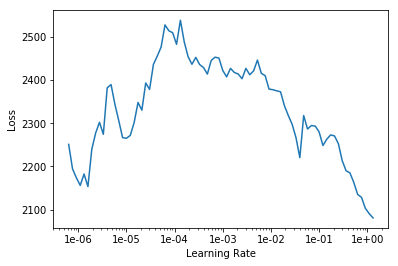

In [103]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,max_lr=slice(1e-4))

epoch,train_loss,valid_loss
1,105.710701,4937.955078
2,104.601051,3355.147705
3,99.907394,10673.331055
4,111.464958,4227.252441
5,93.101135,2796.038086


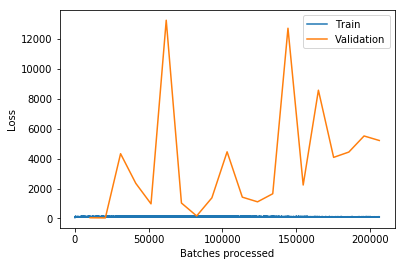

In [107]:
learn.recorder.plot_losses()

In [69]:
learn.load('cnn_lin_not_norm')

Learner(data=TabularDataBunch;

Train: LabelList
y: FloatList (330000 items)
[FloatItem [-47.355 -17.113  38.742], FloatItem [-11.204  20.364  26.554], FloatItem [46.15  18.317 30.18 ], FloatItem [ 39.759 -23.657 -24.338], FloatItem [-36.75  32.06  20.02]]...
Path: data_fcn
x: TabularList (330000 items)
[TabularLine atom_name C; residue_name GLY; chain_id 148; residue_number 45; element_symbol C; x_ca -46.8280; y_ca -16.8620; z_ca 37.3440; , TabularLine atom_name C; residue_name GLU; chain_id 163; residue_number 24; element_symbol C; x_ca -9.7300; y_ca 20.0740; z_ca 26.8810; , TabularLine atom_name HB3; residue_name ARG; chain_id 220; residue_number 86; element_symbol H; x_ca 45.1800; y_ca 16.5750; z_ca 29.6730; , TabularLine atom_name N; residue_name SER; chain_id 219; residue_number 4; element_symbol N; x_ca 39.4490; y_ca -23.4860; z_ca -22.9180; , TabularLine atom_name CA; residue_name LEU; chain_id 216; residue_number 114; element_symbol C; x_ca -36.7500; y_ca 32.0600; z_ca 20.0200

In [48]:
learn.show_results(rows=10)

atom_name,residue_name,chain_id,residue_number,element_symbol,x_ca,y_ca,z_ca,target,prediction
CG2,THR,156,103,C,6.9310,20.8360,14.2790,[ 5.329 19.311 15.425],[ 7.432067 21.548162 17.765903]
CA,LYS,175,112,C,29.9520,96.3320,-11.4320,[ 29.952 96.332 -11.432],[28.349646 90.713104 -5.309415]
CG,ASP,132,46,C,14.5210,-49.2450,5.9810,[ 14.619 -51.773 6.109],[ 14.969724 -41.85605 10.016885]
O,ARG,103,234,O,-27.0670,102.4740,-1.8880,[-26.035 100.33 -2.338],[-22.876226 96.417694 3.248746]
N,ALA,13,28,N,32.7260,64.8240,-22.3320,[ 33.306 63.583 -22.841],[ 31.40509 62.22201 -15.150331]
O,ALA,15,116,O,-24.9970,-16.1350,24.2630,[-27.201 -15.44 23.613],[-21.990404 -11.688196 26.5721 ]
CG1,VAL,71,282,C,19.6640,-0.0340,9.7540,[21.172 -0.145 11.757],[18.859001 2.700073 13.719281]
O,CYS,44,125,O,22.7260,35.3710,16.5450,[25.012 34.746 16.988],[21.490608 35.00641 19.945162]
CG2,THR,158,88,C,23.9920,-5.8570,-26.9500,[ 26.364 -5.544 -27.582],[ 23.06746 -2.485247 -18.984648]
C,TYR,189,183,C,34.2450,89.1610,45.7970,[34.853 87.99 46.498],[31.829557 84.034966 46.14835 ]


In [24]:
%debug

> /home/b/anaconda3/envs/fastai_v1/lib/python3.6/site-packages/torch/nn/functional.py(1352)linear()
   1350     if input.dim() == 2 and bias is not None:
   1351         # fused op is marginally faster
-> 1352         ret = torch.addmm(torch.jit._unwrap_optional(bias), input, weight.t())
   1353     else:
   1354         output = input.matmul(weight.t())

ipdb> u
> /home/b/anaconda3/envs/fastai_v1/lib/python3.6/site-packages/torch/nn/modules/linear.py(67)forward()
     65     @weak_script_method
     66     def forward(self, input):
---> 67         return F.linear(input, self.weight, self.bias)
     68 
     69     def extra_repr(self):

ipdb> u
> /home/b/anaconda3/envs/fastai_v1/lib/python3.6/site-packages/torch/nn/modules/module.py(489)__call__()
    487             result = self._slow_forward(*input, **kwargs)
    488         else:
--> 489             result = self.forward(*input, **kwargs)
    490         for hook in self._forward_hooks.values():
    491             hook_result = h

In [58]:
 t = torch.ones((64,128,123))

In [59]:
t.size()

torch.Size([64, 128, 123])

In [60]:
t=t.view(64,-1)

In [61]:
t.size()

torch.Size([64, 15744])